> From the PO.DAAC Cookbook, to access the original GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/SearchDownload_SWOTviaCMR.ipynb).

Altered version by Ben Kraas

Original version by Cassandra Nickles, PO.DAAC

### Data product description [here](https://deotb6e7tfubr.cloudfront.net/s3-edaf5da92e0ce48fb61175c28b67e95d/podaac-ops-cumulus-docs.s3.us-west-2.amazonaws.com/web-misc/swot_mission_docs/D-109532_SWOT_UserHandbook_20240502.pdf?A-userid=None&Expires=1736359918&Signature=XIxSRPmXacQRvFc-PjYLIofNwogW5xkRRxooqlyXPdc2Jd2Ia2AkdS1Ief~C-P1m7N1EY9DpSVRCvXhoognJ-ac3704DLlLXn3ie1xsuT4ZpjF3TCvj999LnYsVYJizge8GqIyDa91GRDkeDc33zFpLEonEauGSGmxaZBB70FriLFHuQM7ENVGeqd2YCz8X8tIf4wWyJ96QJBkeVfZiQ0ZRsk34Qa8IjqUHbUKlJACTc80KecKrSmtrA2rMC2Ehm6FwW8Ru19-5EbhbZ7deKG0nNtgMTIldtcc85pqc-P14t7OYEHvCUMD2mqUcBCFrocF8TFohjQgAJkTMQPl~-hQ__&Key-Pair-Id=K3RYSLKPMENZFI)

### Powerpoint explaining KaRIn [here](https://swotst.aviso.altimetry.fr/fileadmin/user_upload/SWOTST2023/20230919_3_Karin_overview2/14h10-KaRInFeatures.pdf)


# Search and Download SWOT Data via `earthaccess`

## Summary
This notebook will find and download pre-validated SWOT hydrology data (v2.0) programmatically via earthaccess python library. For more information about earthaccess visit: https://nsidc.github.io/earthaccess/

## Requirements

- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine
- **Earthdata Login**: An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

In [1]:
# Standard library imports
from datetime import datetime
import json
from pathlib import Path
import os
import glob
import zipfile

# Third-party library imports
import geopandas as gpd
import pandas as pd
import contextily as ctx
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import earthaccess

# Matplotlib inline magic command
%matplotlib inline

/home/ben/miniconda3/envs/MB_SWOT_2024/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

## Search for SWOT data links
We want to find the SWOT files for a particular pass over North America. 

Each dataset has it's own unique shortname, which can be used to search earthaccess. Shortnames can be found on dataset landing pages or [Earthdata Search](https://search.earthdata.nasa.gov/search) Collections.

### SWOT Level 2 KaRIn High Rate Version 2.0 Datasets:

- **Water Mask Pixel Cloud NetCDF** - SWOT_L2_HR_PIXC_2.0
- **Water Mask Pixel Cloud Vector Attribute NetCDF** - SWOT_L2_HR_PIXCVec_2.0
- **River Vector Shapefile** - SWOT_L2_HR_RiverSP_2.0
- **Lake Vector Shapefile** - SWOT_L2_HR_LakeSP_2.0
- **Raster NetCDF** - SWOT_L2_HR_Raster_2.0

This notebook can easily be adapted by changing the following variables:

In [2]:
# setup directories and files
data_dir = Path('data')
sampling_points_shapefile = Path("res") / "Reservoirs.shp"
water_mask_pixel_cloud_dir = data_dir / 'Water mask pixel cloud 3'
# lake_vector_shapefile_dir = data_dir / 'lake_vector_shapefiles'

# setup scope
temporal_range = (datetime(2024, 1, 1), datetime(2024, 12, 31))
product_short_name = 'SWOT_L2_HR_PIXC_2.0'

# write to config.json
config = {
    'data_dir': str(data_dir),
    'sampling_points_shapefile': str(sampling_points_shapefile),
    'water_mask_pixel_cloud_dir': str(water_mask_pixel_cloud_dir),
    'temporal_range': (temporal_range[0].isoformat(), temporal_range[1].isoformat()),
    'product_short_name': str(product_short_name),
}
with open('config.json', 'w') as f:
    f.write(json.dumps(config, indent=4))

# ensure data directory exist
data_dir.mkdir(exist_ok=True)


---
# Code section

In [3]:
# authenticate with Earthdata Login
auth = earthaccess.login()
# REVIEW: At some point, a token-based authentication is planned to be implemented by the earthaccess team:
# See: https://github.com/nsidc/earthaccess/issues/484

To find and download the relevant SWOT data, we draw a bounding box around the points of interest and buffer it by an arbitrary amount to ensure coverage around the outermost points. 

/home/ben/miniconda3/envs/MB_SWOT_2024/lib/python3.13/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


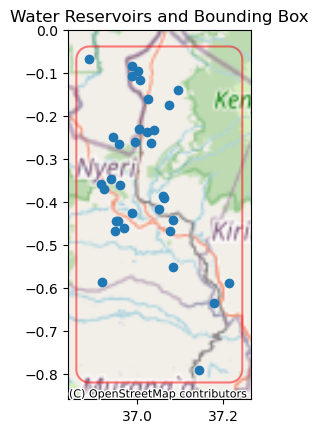

In [4]:
# get the bounding box of the reservoirs
water_reservoirs = gpd.read_file(sampling_points_shapefile)
water_reservoirs = water_reservoirs.to_crs(epsg=4326)
bbox_gdf = gpd.GeoDataFrame(geometry=[water_reservoirs.geometry.union_all().envelope])

# add a buffer to the bounding box to make sure the reservoirs are fully covered. value of 0.03 is arbitrary!
bbox_gdf['geometry'] = bbox_gdf.buffer(0.03)
bbox = bbox_gdf.geometry.union_all().bounds

# add bounding box to the config
with open('config.json', 'r') as f:
    config = json.load(f)
config['bounding_box'] = bbox
with open('config.json', 'w') as f:
    f.write(json.dumps(config, indent=4))

# save the bounding box to a shapefile
bbox_gdf.to_file(data_dir / 'bbox.geojson', driver='GeoJSON')

# plot the bounding box and the reservoirs
ax = water_reservoirs.plot()
bbox_gdf.boundary.plot(ax=ax, color='red', alpha=0.5)
ctx.add_basemap(ax, zoom=8, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:4326') # Default Zoom Level: 10
# add bbox to the plot
ax.set_title('Water Reservoirs and Bounding Box')
ax.set_aspect('equal')

### Download the files
Search for SWOT data in the bounding box region and download it to the datasets directory

In [12]:
def unzip_files(directory):
    for zip_file in list(directory.glob('*.zip')):
         with zipfile.ZipFile(zip_file, 'r') as zip_ref:
             zip_ref.extractall(directory)

def download_swot_data(product_short_name, temporal_range, bbox, data_dir):
    """
    Downloads SWOT data from the Earthdata API.
    
    Parameters:
        product_short_name (str): The short name of the SWOT product to download.
        temporal_range (tuple): The temporal range of the data to download.
        bbox (tuple): The bounding box of the region to download the data from.
        data_dir (Path): The directory to download the data to.
        
    Returns:
        None
    """
    if data_dir.exists() and len(list(data_dir.glob('*.zip'))) > 0:
        print(f"Found {len(list(data_dir.glob('*.zip')))} existing files in {data_dir}. Skipping download.")
    else:
        print(f"Downloading SWOT data for {product_short_name}...")
        results = earthaccess.search_data(short_name = product_short_name,
                                        temporal = (temporal_range[0].isoformat(), temporal_range[1].isoformat()),
                                        bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3]))
        print(f"Found {len(results)} pixel cloud files in the region.")
        earthaccess.download(results, data_dir)

# # ---------
# # This code may not be necessary as the vector data is quite useless... It can be uncommented for testing purposes.
# 
# download_swot_data("SWOT_L2_HR_RiverSP_2.0", temporal_range, bbox, lake_vector_shapefile_dir)
# unzip_files(lake_vector_shapefile_dir)
# 
# # ---------


# Download the pixel cloud data
download_swot_data(product_short_name, temporal_range, bbox, water_mask_pixel_cloud_dir)

Found 113 pixel cloud files in the region.


QUEUEING TASKS | :   0%|          | 0/113 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/113 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/113 [00:00<?, ?it/s]

# Processing
So far, this is what I (BK) have interpreted from my understanding of the SWOT data, the data that is available and the task at hand.


## First approach [DEPRECATED]: 
EDIT: This approach is not feasible - the vector files are too rough to be used for this purpose. A different approach will be needed.
With both the pixel cloud and vector attribute files, we can 
1. Identify the lake vectors that contain a sample point
2. Clip the pixel cloud using the lake vectors
3. Aggregate the pixel cloud values over the lake vectors
4. Calculate the lake water level from the aggregated pixel cloud values

## Modified approach [PROPOSED BY BK, PENDING APPROVAL]:
1. Verify that in close proximity to each sampling point, there are pixel cloud points (within a certain distance threshold)
    - A flag may need to be set to indicate that a pixel cloud point is or is not within the distance threshold to identify if in proximity to a sampling point corresponding values could be found.
2. Get the nearest pixel cloud point to each sampling point and then determine a cloud cluster around each sampling point walking through the pixel cloud points at a certain distance threshold
3. This cluster could be structured by a list of pixel cloud points that are within the distance threshold of the sampling point 
4. The resulting dataframe can either be structured using a multi-index structure, dataframe nesting (temporally or spatially) or a concatenated single dataframe containing both datetime and cluster id.

Notes:
Source: https://swotst.aviso.altimetry.fr/fileadmin/user_upload/SWOTST2023/20230919_3_Karin_overview2/14h10-KaRInFeatures.pdf

SSH and PIXC height are referenced to ellipsoid

- Ellipsoid parameters are given in metadata of every single KaRIn product granule
- As of Sept 2023: WGS84
    - ellipsoid_semi_major_axis = 6378137. ;
    - ellipsoid_flattening = 0.00335281066474748 ;

L2_HR_PIXC product contains variable pixc_line_qual to indicate whether data
were collected



{'azimuth_index': <class 'netCDF4.Variable'>
int32 azimuth_index(points)
    _FillValue: 2147483647
    long_name: rare interferogram azimuth index
    units: 1
    valid_min: 0
    valid_max: 999999
    coordinates: longitude latitude
    comment: Rare interferogram azimuth index (indexed from 0).
path = /pixel_cloud
unlimited dimensions: 
current shape = (4434973,)
filling on, 'range_index': <class 'netCDF4.Variable'>
int32 range_index(points)
    _FillValue: 2147483647
    long_name: rare interferogram range index
    units: 1
    valid_min: 0
    valid_max: 999999
    coordinates: longitude latitude
    comment: Rare interferogram range index (indexed from 0).
path = /pixel_cloud
unlimited dimensions: 
current shape = (4434973,)
filling on, 'interferogram': <class 'netCDF4.Variable'>
float32 interferogram(points, complex_depth)
    _FillValue: 9.96921e+36
    long_name: rare interferogram
    units: 1
    quality_flag: interferogram_qual
    valid_min: -1e+20
    valid_max: 1e+20


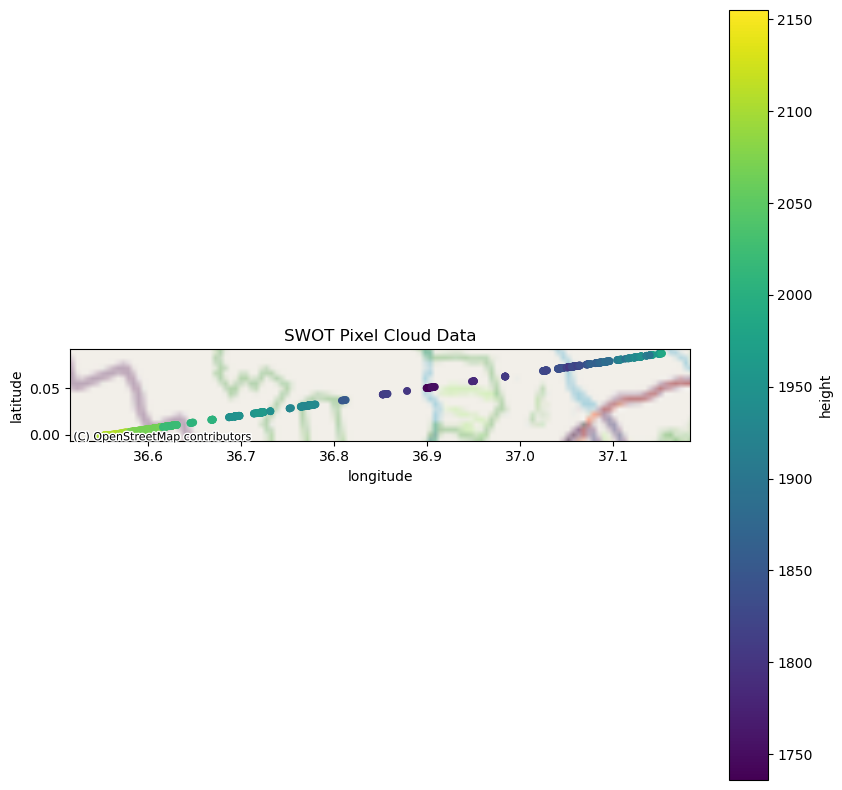